# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 256 #Change batch size from 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([256, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([256, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

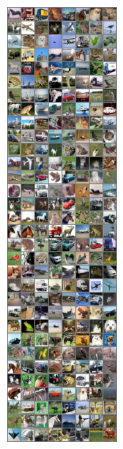

In [4]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [29]:
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.dropout import Dropout2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.container import Sequential
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # activation_fn = nn.ReLU

        activation_fn = nn.LeakyReLU

                

        self.conv_part = nn.Sequential(
            # CONV1
            nn.Conv2d(3,32,3,padding='same'),
            activation_fn(),
            nn.BatchNorm2d(32),

            # CONV2
            nn.Conv2d(32,32,3,padding='same'),
            activation_fn(),
            nn.BatchNorm2d(32),

            # Pool and Dropout
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),

            # CONV3
            nn.Conv2d(32,64,3,padding='same'),
            activation_fn(),
            nn.BatchNorm2d(64),

            # CONV4
            nn.Conv2d(64,64,3,padding='same'),
            activation_fn(),
            nn.BatchNorm2d(64),

            # Pool and Dropout
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            # CONV5
            nn.Conv2d(64,128, 3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(128),

            # CONV6
            nn.Conv2d(128, 128,3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(128),

            # Pool and Dropout
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),

            # CONV7
            nn.Conv2d(128,256, 3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(256),

            # CONV8
            nn.Conv2d(256, 256,3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(256),

            # Pool and Dropout
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),

            # CONV9
            nn.Conv2d(256,512, 3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(512),

            # CONV10
            nn.Conv2d(512, 512,3, padding='same'),
            activation_fn(),
            nn.BatchNorm2d(512),

            # Pool and Dropout
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),

            # Flatten
            nn.Flatten()


        )
        
        output_dims_conv_part = self.get_conv_part_out_dims(torch.randn(1, 3, 32, 32))[1]
        

        

        self.dense_part = nn.Sequential(
            
            # Dense1            
            nn.Linear(output_dims_conv_part, 10),
            
            
        )

        
    
    def get_conv_part_out_dims(self, input_data):
        '''
        Get the dimensions after flattening the last convolutional layer
        Output is the size of the flattened tensor after pushing it through the concolutional part
        Input is a 4d test tensor (batch_size, channels, height, width). The batch size is not important, can be 1.
        '''
        x = self.conv_part(input_data)
        return x.size()

    def forward(self, x):
        x = self.conv_part(x)
        return self.dense_part(x)


model = Model(n_classes)
device = torch.device('cuda')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv_part): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): LeakyReLU(negative_slope=0.01)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_siz

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [30]:
# Loss function
loss_fn = nn.CrossEntropyLoss() # multiclass classification

# Optimizer
lr = 1.5*1e-3 #1e-3
weight_decay = 1e-4 #1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay) 

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.85) # decrease the learning rate after 30 epochs to 0.85 times the previous lr


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [27]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.04192882  2.1142385   2.985258    2.1519063  -0.3508377  -1.3376064
   0.34588313 -1.8838671   0.82977384 -0.5367922 ]
 [-0.6804791   0.44476533  0.49571776  1.8375667  -0.11586728 -1.0336082
  -0.46363944 -1.5734311   0.5662721   0.69085413]]
Output probabilities:
[[0.02227794 0.19243611 0.4597964  0.19982299 0.01635752 0.00609775
  0.03283216 0.00353127 0.05326607 0.01358184]
 [0.03198998 0.09856016 0.10371219 0.39681438 0.05626285 0.02247253
  0.03973619 0.01309814 0.11129384 0.12605976]]


In [31]:
num_epochs = 200 #150
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = loss_fn(output, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Perform one training step
        optimizer.step()
        
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}    Epoch {epoch+1}/{num_epochs}")
            print(f"             test accuracy: {valid_accuracies[-1]}")
    scheduler.step()
print("Finished training.")

Step 500     training accuracy: 0.6390697337962963    Epoch 3/200
             test accuracy: 0.6956
Step 1000    training accuracy: 0.76328125    Epoch 6/200
             test accuracy: 0.7845
Step 1500    training accuracy: 0.794342041015625    Epoch 8/200
             test accuracy: 0.8061
Step 2000    training accuracy: 0.82158203125    Epoch 11/200
             test accuracy: 0.8269
Step 2500    training accuracy: 0.8407411317567568    Epoch 13/200
             test accuracy: 0.8271
Step 3000    training accuracy: 0.862890625    Epoch 16/200
             test accuracy: 0.8412
Step 3500    training accuracy: 0.8663504464285714    Epoch 18/200
             test accuracy: 0.8464
Step 4000    training accuracy: 0.8794921875    Epoch 21/200
             test accuracy: 0.8411
Step 4500    training accuracy: 0.884038397606383    Epoch 23/200
             test accuracy: 0.8528
Step 5000    training accuracy: 0.897109375    Epoch 26/200
             test accuracy: 0.8551
Step 5500    train

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

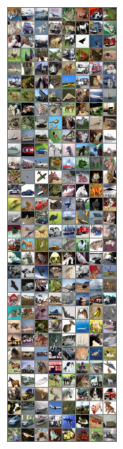

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          deer     
    horse         horse    
    truck         truck    
    ship          frog     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          truck    
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [32]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [33]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [34]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.872


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


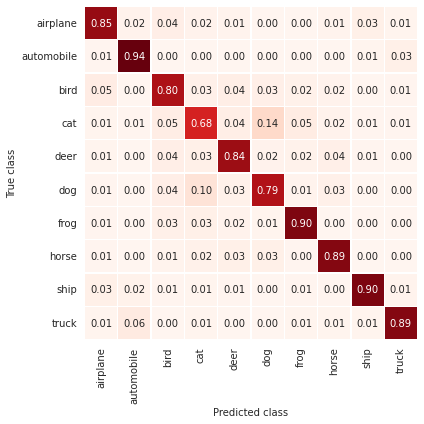

In [13]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

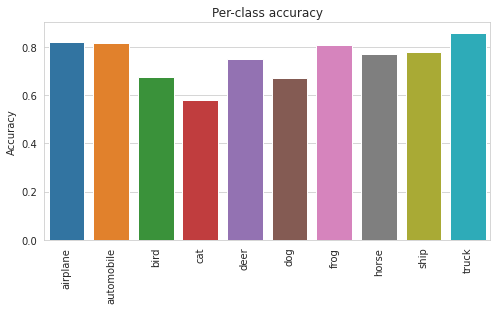

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.  
---
**Answer:**  

1. The answer is in the code above.  

2. Initially, I started with a simple network architecture. I used 2 convolutional layers, each with a max pooling layer and filters of size 5$\times$5 and 3$\times$3 respectively. For the dense part, I used 1 layer of 512 neurons and the output layer of 10 neurons. No batch normalisation or weight decay. This gave average test accuracy around 60\%.

  As I increased the convolutional layers, the performance increased. To overcome the plateau of 80% accuracy, I introduced max pooling and dropout layers after every 2 convolutional layers, as well as include batch normalisation after the activation function of each output.

  For the dense part As the layers increased, the performance increase was marginal. But the average accuracy reached 83\%.

  The dense part architecture was challenging to decide on. Even if there were more layers, the performance increase was marginal, if not worse. Probably due to overfitting, or because more training was needed.

  The cat class is the most difficult to classify correctly, most often confused with the dog class, and the deer class afterwards.

  The Dropout layer decreased the training time by a large margin. This allowed to also increase the batch size to 256, which also increased accuracy. Max pooling also plays a role in decreasing the training time, since it reduces the number of weights after it, by essentially downsampling the feature maps.  

3. Dropout layer is essential, GPU is needed for training times to be manageable, max pooling is also essential, but not after each convolutional layer. Moreover, batch normalisation after each convolutional layer increases accuracy. The accuracy can be increased if a lot of training time is allowed and the learning rate is efficiently changed to speed up training. More epochs are also needed as it seems now, with this architecture.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['Tesla T4']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





#### [Exercise](http://neuralnetworksanddeeplearning.com/chap3.html#exercise_195778):
> As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images?  
---  
Data augmentation is a way to avoid overfitting, by artificaially increasing the available data set. By allowing rotation (and scaling) of each labeled training data point, an image, it is possible to have more training points.   

However, allowing arbitrary rotations might become problematic. Since each image that is rotated is already labeled, the rotated image might now have a different meaning when encoutered in the real world. An example is to have an image of 6, rotate it by 180$^{o}$ and receive an image of a 9. However, this is still labeled as a 6. Moreover, a reflection of a digit might not represent an actual digit. 

As a result, allowing arbitrary rotation can hurt the ability of the model to generalise. The effect of the augmentation on the labels must be examined (eg. 6 to 9), as well as the distribution of the images in the data set in the real world (eg. there are no digits represented by a reflection of 3).
